# Functions to move to general_utils module

In [1]:
# create a list of letters
def char_range(c1, c2):
    """Generates the characters from `c1` to `c2`, inclusive."""
    for c in range(ord(c1), ord(c2) + 1):
        yield chr(c)

# create list of wells in range
def well_range(c1,n1,c2,n2):
    well_order_by_columns = [
            f"{w}{n:1}" for n in range(n1, n2) for w in char_range(c1, c2)
        ]
    return well_order_by_columns

In [2]:
# convert ensembl to gene symbol
def convert_ensembl_symbol(adata,species='human',idcol = 'ensembls'):
    import mygene
    mg = mygene.MyGeneInfo()

    mygene_converter = mg.querymany(list(adata.var[idcol]),scopes='all', species=species, as_dataframe=True)
    mygene_converter.loc[mygene_converter['notfound']==True,'symbol'] = mygene_converter.loc[mygene_converter['notfound']==True].index

    adata.var = adata.var.merge(
        mygene_converter.reset_index(),left_on='ensembls',right_on='query').sort_values(
        by='_score',ascending=False).drop_duplicates(
        'ensembl_id').set_index('symbol')
    
    return adata

In [43]:
import logging as logg
def downsample_to_smallest_category(
        adata,
        column="sample_short",
        random_state=None,
        min_cells=15,
        keep_small_categories=False
) -> sc.AnnData:
    """
    returns an annData object in which all categories in 'column' have
    the same size

    column
        column with the categories to downsample
    min_cells
        Minimum number of cells to downsample.
        Categories having less than `min_cells` are discarded unless
        keep_small_categories is True
    keep_small_categories
        Be default categories with less than min_cells are discarded.
        Set to true to keep them
    """
    counts = adata.obs[column].value_counts(sort=False)
    if len(counts[counts < min_cells]) > 0 and keep_small_categories is False:
        logg.warning(
            "The following categories have less than {} cells and will be "
            "ignored: {}".format(min_cells, dict(counts[counts < min_cells]))
        )
    min_size = min(counts[counts >= min_cells])
    sample_selection = None
    for sample, num_cells in counts.items():
        if num_cells <= min_cells:
            if keep_small_categories:
                sel = adata.obs.index.isin(
                    adata.obs[adata.obs[column] == sample].index)
            else:
                continue
        else:
            sel = adata.obs.index.isin(
                adata.obs[adata.obs[column] == sample]
                .sample(min_size, random_state=random_state)
                .index
            )
        if sample_selection is None:
            sample_selection = sel
        else:
            sample_selection |= sel
    logg.info(
        "The cells in category {!r} had been down-sampled to have each {} cells. "
        "The original counts where {}".format(column, min_size, dict(counts))
    )
    return adata[sample_selection].copy()

# Packages needed

In [3]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns

sc.settings.verbosity = 3   

/home/angela/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [25]:
sc.__version__


'1.4.5.1'

# Load gene count table

In [4]:
adata = sc.read_csv('/mnt/ibm_lg/angela/sapiens/TSP2/smartseq2/tsp2_ss2_batch1.csv')
adata = adata.transpose()
adata

AnnData object with n_obs × n_vars = 7656 × 58967 

Remove htseq last 5lines

In [5]:
display(adata.var_names[-10:])
adata = adata[:,:-5].copy()
display(adata.var_names[-10:])
adata

Index(['ERCC-00164', 'ERCC-00165', 'ERCC-00168', 'ERCC-00170', 'ERCC-00171',
       '__no_feature', '__ambiguous', '__too_low_aQual', '__not_aligned',
       '__alignment_not_unique'],
      dtype='object')

Index(['ERCC-00157', 'ERCC-00158', 'ERCC-00160', 'ERCC-00162', 'ERCC-00163',
       'ERCC-00164', 'ERCC-00165', 'ERCC-00168', 'ERCC-00170', 'ERCC-00171'],
      dtype='object')

AnnData object with n_obs × n_vars = 7656 × 58962 

In [6]:
adata.obs.head()

""
TSP2_Bladder_NA_SS2_B113692_B104865_Empty_A15_S15.homo.gencode.v30.ERCC.chrM
TSP2_Bladder_NA_SS2_B113692_B104865_Empty_A16_S16.homo.gencode.v30.ERCC.chrM
TSP2_Bladder_NA_SS2_B113692_B104865_Empty_A17_S17.homo.gencode.v30.ERCC.chrM
TSP2_Bladder_NA_SS2_B113692_B104865_Empty_A18_S18.homo.gencode.v30.ERCC.chrM
TSP2_Bladder_NA_SS2_B113692_B104865_Empty_A19_S19.homo.gencode.v30.ERCC.chrM


In [7]:
adata.obs['pilot'] = [c.split('_')[0] for c in adata.obs.index]
adata.obs['Tissue'] = [c.split('_')[1] for c in adata.obs.index]
adata.obs['AnatomicalPosition'] = [c.split('_')[2] for c in adata.obs.index]
adata.obs['method'] = [c.split('_')[3] for c in adata.obs.index]
adata.obs['cDNAPlate'] = [c.split('_')[4] for c in adata.obs.index]
adata.obs['LibraryPlateID'] = [c.split('_')[5] for c in adata.obs.index]
adata.obs['population'] = [c.split('_')[6] for c in adata.obs.index]
adata.obs['well_seq'] = [c.split('_')[7] for c in adata.obs.index]
adata.obs['cell_id'] = [c.split('.')[0] for c in adata.obs.index]

Convert ensembl ids to gene symbol

In [8]:
adata.var_names

Index(['ENSG00000000003.14', 'ENSG00000000005.6', 'ENSG00000000419.12',
       'ENSG00000000457.14', 'ENSG00000000460.17', 'ENSG00000000938.13',
       'ENSG00000000971.15', 'ENSG00000001036.13', 'ENSG00000001084.12',
       'ENSG00000001167.14',
       ...
       'ERCC-00157', 'ERCC-00158', 'ERCC-00160', 'ERCC-00162', 'ERCC-00163',
       'ERCC-00164', 'ERCC-00165', 'ERCC-00168', 'ERCC-00170', 'ERCC-00171'],
      dtype='object', length=58962)

In [9]:
adata.var['ensembl_id'] = adata.var_names
adata.var['ensembls'] = [g.split(".")[0] for g in adata.var['ensembl_id']]
adata.var

,ensembl_id,ensembls
ENSG00000000003.14,ENSG00000000003.14,ENSG00000000003
ENSG00000000005.6,ENSG00000000005.6,ENSG00000000005
ENSG00000000419.12,ENSG00000000419.12,ENSG00000000419
ENSG00000000457.14,ENSG00000000457.14,ENSG00000000457
ENSG00000000460.17,ENSG00000000460.17,ENSG00000000460
...,...,...
ERCC-00164,ERCC-00164,ERCC-00164
ERCC-00165,ERCC-00165,ERCC-00165
ERCC-00168,ERCC-00168,ERCC-00168
ERCC-00170,ERCC-00170,ERCC-00170


In [10]:
adata = convert_ensembl_symbol(adata);

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-28000...done.
querying 28001-29000...done.
querying 29001-30000...done.
querying 30001-31000...done.
querying 31001-32000...done.
querying 32001-33000...done.
querying 33001-34000...done.
querying 34001-35000...done.
queryin

/home/angela/anaconda3/lib/python3.7/site-packages/biothings_client/base.py:143: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = json_normalize(obj)


47 input query terms found dup hits:
	[('ENSG00000002586', 2), ('ENSG00000124333', 2), ('ENSG00000124334', 2), ('ENSG00000167393', 2), ('E
205 input query terms found no hit:
	['ENSG00000116883', 'ENSG00000130489', 'ENSG00000168078', 'ENSG00000170165', 'ENSG00000181013', 'ENS
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [11]:
adata.write_h5ad('/mnt/ibm_lg/angela/sapiens/TSP2/smartseq2/TSP2_SS2_no_official_metadata_unfiltered_raw.h5ad')
adata

... storing 'pilot' as categorical
... storing 'Tissue' as categorical
... storing 'AnatomicalPosition' as categorical
... storing 'method' as categorical
... storing 'cDNAPlate' as categorical
... storing 'LibraryPlateID' as categorical
... storing 'population' as categorical
... storing 'well_seq' as categorical
... storing 'ensembls' as categorical
... storing 'query' as categorical
... storing '_id' as categorical
... storing 'entrezgene' as categorical
... storing 'name' as categorical
... storing 'notfound' as categorical


AnnData object with n_obs × n_vars = 7656 × 58962 
    obs: 'pilot', 'Tissue', 'AnatomicalPosition', 'method', 'cDNAPlate', 'LibraryPlateID', 'population', 'well_seq', 'cell_id'
    var: 'ensembl_id', 'ensembls', 'query', '_id', '_score', 'entrezgene', 'name', 'taxid', 'notfound'

# QC

In [57]:
adata = sc.read_h5ad(
    '/mnt/ibm_lg/angela/sapiens/TSP2/smartseq2/TSP2_SS2_no_official_metadata_unfiltered_raw.h5ad')
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 7656 × 58962 
    obs: 'pilot', 'Tissue', 'AnatomicalPosition', 'method', 'cDNAPlate', 'LibraryPlateID', 'population', 'well_seq', 'cell_id'
    var: 'ensembl_id', 'ensembls', 'query', '_id', '_score', 'entrezgene', 'name', 'taxid', 'notfound'

In [58]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, min_counts=2500)
sc.pp.filter_genes(adata, min_cells=0)

filtered out 3556 cells that have less than 200 genes expressed


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


filtered out 109 cells that have less than 2500 counts


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [14]:
adata.write(
    '/mnt/ibm_lg/angela/sapiens/TSP2/smartseq2/TSP2_SS2_no_official_metadata_filtered_raw.h5ad')
adata

AnnData object with n_obs × n_vars = 3991 × 58962 
    obs: 'pilot', 'Tissue', 'AnatomicalPosition', 'method', 'cDNAPlate', 'LibraryPlateID', 'population', 'well_seq', 'cell_id', 'n_genes', 'n_counts'
    var: 'ensembl_id', 'ensembls', 'query', '_id', '_score', 'entrezgene', 'name', 'taxid', 'notfound', 'n_cells'

In [15]:
mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']

In [16]:
ercc_gene_mask = [gene.startswith('ERCC') for gene in adata.var_names]
adata.obs['ercc_frac'] = adata.X[:, ercc_gene_mask].sum(1)/adata.obs['n_counts']

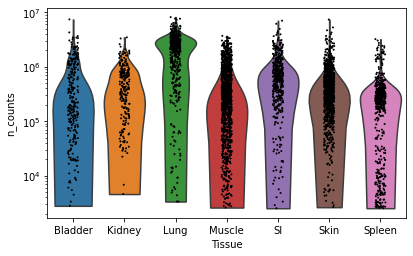

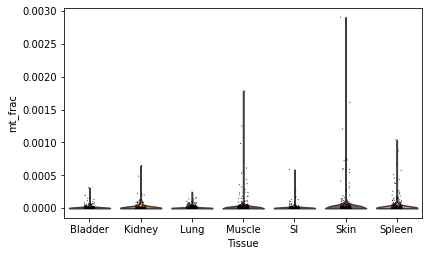

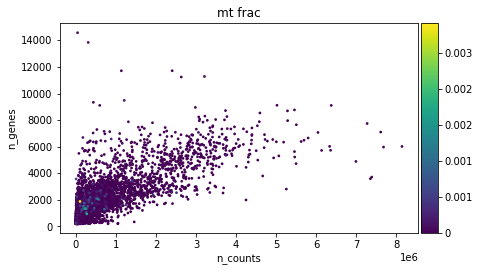

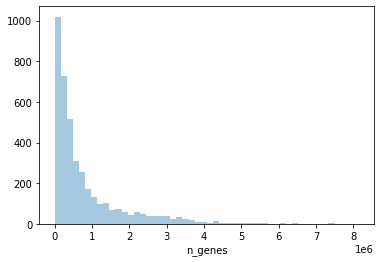

In [17]:
sc.pl.violin(adata, 'n_counts', groupby='Tissue', size=2, log=True, cut=0)
sc.pl.violin(adata, 'mt_frac', groupby='Tissue')

sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac')

sns.distplot(adata.obs['n_counts'], kde=False)
sns.distplot(adata.obs['n_genes'], kde=False, bins=60)

In [18]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [19]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)
sc.pp.log1p(adata)
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
# sc.tl.louvain(adata, key_added='groups', resolution=0.5)

normalizing by total count per cell


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


    finished (0:00:06): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 50
    finished (0:00:24)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:13)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:35)


In [20]:
adata.obs.head()

,pilot,Tissue,AnatomicalPosition,method,cDNAPlate,LibraryPlateID,population,well_seq,cell_id,n_genes,n_counts,mt_frac,ercc_frac
TSP2_Bladder_NA_SS2_B113692_B104865_Empty_G15_S159.homo.gencode.v30.ERCC.chrM,TSP2,Bladder,NA,SS2,B113692,B104865,Empty,G15,TSP2_Bladder_NA_SS2_B113692_B104865_Empty_G15_...,14572,41078.0,0.000073,0.000049
TSP2_Bladder_NA_SS2_B113692_B104865_Empty_O14_S350.homo.gencode.v30.ERCC.chrM,TSP2,Bladder,NA,SS2,B113692,B104865,Empty,O14,TSP2_Bladder_NA_SS2_B113692_B104865_Empty_O14_...,3965,1142832.0,0.000000,0.003594
TSP2_Bladder_NA_SS2_B113692_B104865_Empty_P14_S374.homo.gencode.v30.ERCC.chrM,TSP2,Bladder,NA,SS2,B113692,B104865,Empty,P14,TSP2_Bladder_NA_SS2_B113692_B104865_Empty_P14_...,1909,884479.0,0.000000,0.016488
TSP2_Bladder_NA_SS2_B113692_B104865_Epithelial_A11_S11.homo.gencode.v30.ERCC.chrM,TSP2,Bladder,NA,SS2,B113692,B104865,Epithelial,A11,TSP2_Bladder_NA_SS2_B113692_B104865_Epithelial...,6533,1782488.0,0.000003,0.001535
TSP2_Bladder_NA_SS2_B113692_B104865_Epithelial_A2_S2.homo.gencode.v30.ERCC.chrM,TSP2,Bladder,NA,SS2,B113692,B104865,Epithelial,A2,TSP2_Bladder_NA_SS2_B113692_B104865_Epithelial...,1759,28081.0,0.000000,0.002528


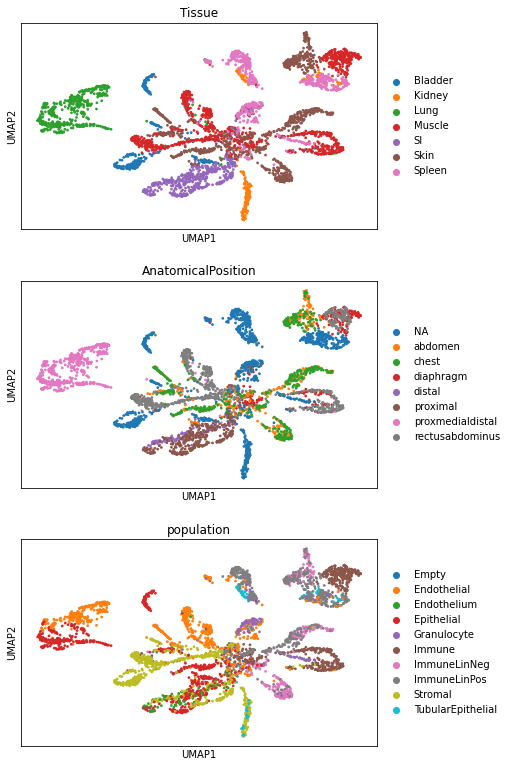

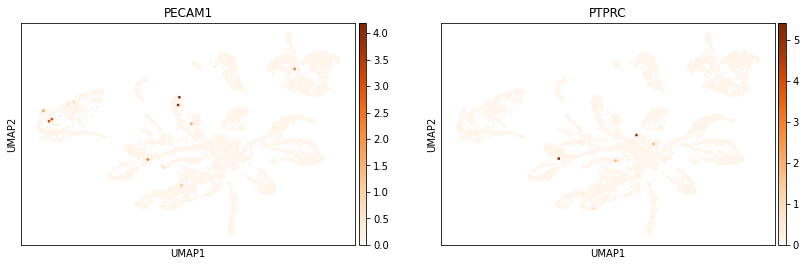

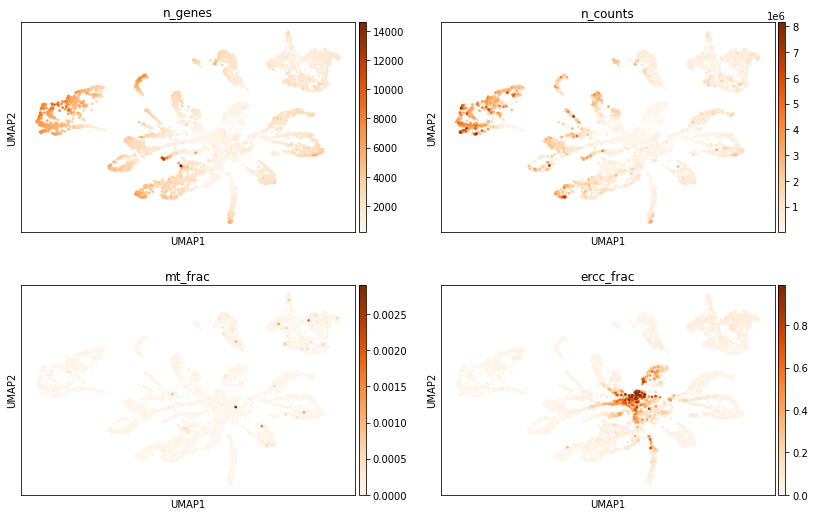

In [21]:
sc.pl.umap(adata,color = ['Tissue','AnatomicalPosition','population'],ncols=1)
sc.pl.umap(adata,color = ['PECAM1','PTPRC'], cmap='Oranges')
sc.pl.umap(adata,color = ['n_genes','n_counts','mt_frac','ercc_frac'],cmap='Oranges',ncols=2)

In [22]:
adata.write_h5ad(
    '/mnt/ibm_lg/angela/sapiens/TSP2/smartseq2/TSP2_SS2_no_official_metadata_counts_layer_processed_X.h5ad')
adata

AnnData object with n_obs × n_vars = 3991 × 58962 
    obs: 'pilot', 'Tissue', 'AnatomicalPosition', 'method', 'cDNAPlate', 'LibraryPlateID', 'population', 'well_seq', 'cell_id', 'n_genes', 'n_counts', 'mt_frac', 'ercc_frac'
    var: 'ensembl_id', 'ensembls', 'query', '_id', '_score', 'entrezgene', 'name', 'taxid', 'notfound', 'n_cells'
    uns: 'Tissue_colors', 'log1p', 'pca', 'neighbors', 'umap', 'AnatomicalPosition_colors', 'population_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

In [45]:
adata1 = adata.copy()
adata1

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 3991 × 58962 
    obs: 'pilot', 'Tissue', 'AnatomicalPosition', 'method', 'cDNAPlate', 'LibraryPlateID', 'population', 'well_seq', 'cell_id', 'n_genes', 'n_counts', 'mt_frac', 'ercc_frac'
    var: 'ensembl_id', 'ensembls', 'query', '_id', '_score', 'entrezgene', 'name', 'taxid', 'notfound', 'n_cells'
    uns: 'Tissue_colors', 'log1p', 'pca', 'neighbors', 'umap', 'AnatomicalPosition_colors', 'population_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

In [30]:
adata2 = adata[adata.obs['Tissue']=='Bladder'].copy()
adata2

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 268 × 58962 
    obs: 'pilot', 'Tissue', 'AnatomicalPosition', 'method', 'cDNAPlate', 'LibraryPlateID', 'population', 'well_seq', 'cell_id', 'n_genes', 'n_counts', 'mt_frac', 'ercc_frac'
    var: 'ensembl_id', 'ensembls', 'query', '_id', '_score', 'entrezgene', 'name', 'taxid', 'notfound', 'n_cells'
    uns: 'Tissue_colors', 'log1p', 'pca', 'neighbors', 'umap', 'AnatomicalPosition_colors', 'population_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

In [33]:
adata2.shape[0]

268

In [ ]:
downsample_to_smallest_category(adata1)

In [38]:
sc.pp.subsample(adata1, n_obs=adata2.shape[0]) 
adata1

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 268 × 58962 
    obs: 'pilot', 'Tissue', 'AnatomicalPosition', 'method', 'cDNAPlate', 'LibraryPlateID', 'population', 'well_seq', 'cell_id', 'n_genes', 'n_counts', 'mt_frac', 'ercc_frac'
    var: 'ensembl_id', 'ensembls', 'query', '_id', '_score', 'entrezgene', 'name', 'taxid', 'notfound', 'n_cells'
    uns: 'Tissue_colors', 'log1p', 'pca', 'neighbors', 'umap', 'AnatomicalPosition_colors', 'population_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

In [47]:
downsample_to_smallest_category(adata1, 'Tissue', min_cells=100, keep_small_categories=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 1582 × 58962 
    obs: 'pilot', 'Tissue', 'AnatomicalPosition', 'method', 'cDNAPlate', 'LibraryPlateID', 'population', 'well_seq', 'cell_id', 'n_genes', 'n_counts', 'mt_frac', 'ercc_frac'
    var: 'ensembl_id', 'ensembls', 'query', '_id', '_score', 'entrezgene', 'name', 'taxid', 'notfound', 'n_cells'
    uns: 'Tissue_colors', 'log1p', 'pca', 'neighbors', 'umap', 'AnatomicalPosition_colors', 'population_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

In [49]:
adata1 = downsample_to_smallest_category(adata1, 'Tissue', min_cells=100, keep_small_categories=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [52]:
adata.obs.columns

Index(['pilot', 'Tissue', 'AnatomicalPosition', 'method', 'cDNAPlate',
       'LibraryPlateID', 'population', 'well_seq', 'cell_id', 'n_genes',
       'n_counts', 'mt_frac', 'ercc_frac'],
      dtype='object')

In [51]:
adata.obs.groupby(['Tissue','']).count()

,pilot,AnatomicalPosition,method,cDNAPlate,LibraryPlateID,population,well_seq,cell_id,n_genes,n_counts,mt_frac,ercc_frac
Tissue,,,,,,,,,,,,
Bladder,268,268,268,268,268,268,268,268,268,268,268,268
Kidney,226,226,226,226,226,226,226,226,226,226,226,226
Lung,490,490,490,490,490,490,490,490,490,490,490,490
Muscle,1098,1098,1098,1098,1098,1098,1098,1098,1098,1098,1098,1098
SI,477,477,477,477,477,477,477,477,477,477,477,477
Skin,877,877,877,877,877,877,877,877,877,877,877,877
Spleen,555,555,555,555,555,555,555,555,555,555,555,555


In [ ]:
import logging as logg
def downsample_to_smallest_category(
        adata,
        column="sample_short",
        random_state=None,
        min_cells=15,
        keep_small_categories=False
) -> sc.AnnData:
    """
    returns an annData object in which all categories in 'column' have
    the same size

    column
        column with the categories to downsample
    min_cells
        Minimum number of cells to downsample.
        Categories having less than `min_cells` are discarded unless
        keep_small_categories is True
    keep_small_categories
        Be default categories with less than min_cells are discarded.
        Set to true to keep them
    """
    counts = adata.obs[column].value_counts(sort=False)
    if len(counts[counts < min_cells]) > 0 and keep_small_categories is False:
        logg.warning(
            "The following categories have less than {} cells and will be "
            "ignored: {}".format(min_cells, dict(counts[counts < min_cells]))
        )
    min_size = min(counts[counts >= min_cells])
    sample_selection = None
    for sample, num_cells in counts.items():
        if num_cells <= min_cells:
            if keep_small_categories:
                sel = adata.obs.index.isin(
                    adata.obs[adata.obs[column] == sample].index)
            else:
                continue
        else:
            sel = adata.obs.index.isin(
                adata.obs[adata.obs[column] == sample]
                .sample(min_size, random_state=random_state)
                .index
            )
        if sample_selection is None:
            sample_selection = sel
        else:
            sample_selection |= sel
    logg.info(
        "The cells in category {!r} had been down-sampled to have each {} cells. "
        "The original counts where {}".format(column, min_size, dict(counts))
    )
    return adata[sample_selection].copy()

In [56]:
adata1 = adata.copy()
display(adata1)
display(adata1.obs.groupby('Tissue').count())
adata1.obs['classification_group'] = 'B'
adata1.obs.loc[adata1.obs[adata1.obs['Tissue']=='Bladder'].index,'classification_group'] = 'A'
adata1 = downsample_to_smallest_category(adata1, 'classification_group', keep_small_categories=True)
display(adata1)
display(adata1.obs.groupby('Tissue').count())

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 3991 × 58962 
    obs: 'pilot', 'Tissue', 'AnatomicalPosition', 'method', 'cDNAPlate', 'LibraryPlateID', 'population', 'well_seq', 'cell_id', 'n_genes', 'n_counts', 'mt_frac', 'ercc_frac'
    var: 'ensembl_id', 'ensembls', 'query', '_id', '_score', 'entrezgene', 'name', 'taxid', 'notfound', 'n_cells'
    uns: 'Tissue_colors', 'log1p', 'pca', 'neighbors', 'umap', 'AnatomicalPosition_colors', 'population_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

,pilot,AnatomicalPosition,method,cDNAPlate,LibraryPlateID,population,well_seq,cell_id,n_genes,n_counts,mt_frac,ercc_frac
Tissue,,,,,,,,,,,,
Bladder,268,268,268,268,268,268,268,268,268,268,268,268
Kidney,226,226,226,226,226,226,226,226,226,226,226,226
Lung,490,490,490,490,490,490,490,490,490,490,490,490
Muscle,1098,1098,1098,1098,1098,1098,1098,1098,1098,1098,1098,1098
SI,477,477,477,477,477,477,477,477,477,477,477,477
Skin,877,877,877,877,877,877,877,877,877,877,877,877
Spleen,555,555,555,555,555,555,555,555,555,555,555,555


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 536 × 58962 
    obs: 'pilot', 'Tissue', 'AnatomicalPosition', 'method', 'cDNAPlate', 'LibraryPlateID', 'population', 'well_seq', 'cell_id', 'n_genes', 'n_counts', 'mt_frac', 'ercc_frac', 'classification_group'
    var: 'ensembl_id', 'ensembls', 'query', '_id', '_score', 'entrezgene', 'name', 'taxid', 'notfound', 'n_cells'
    uns: 'Tissue_colors', 'log1p', 'pca', 'neighbors', 'umap', 'AnatomicalPosition_colors', 'population_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'

,pilot,AnatomicalPosition,method,cDNAPlate,LibraryPlateID,population,well_seq,cell_id,n_genes,n_counts,mt_frac,ercc_frac,classification_group
Tissue,,,,,,,,,,,,,
Bladder,268,268,268,268,268,268,268,268,268,268,268,268,268
Kidney,15,15,15,15,15,15,15,15,15,15,15,15,15
Lung,27,27,27,27,27,27,27,27,27,27,27,27,27
Muscle,80,80,80,80,80,80,80,80,80,80,80,80,80
SI,31,31,31,31,31,31,31,31,31,31,31,31,31
Skin,66,66,66,66,66,66,66,66,66,66,66,66,66
Spleen,49,49,49,49,49,49,49,49,49,49,49,49,49
